# Support Vector Machine Classification

## Samuel Levin, samuel.levin@utdallas.edu

### Verify python interpreter (with necessary libraries installed), bulk import

In [1]:
import sys
sys.executable

'C:\\Users\\samle\\AppData\\Local\\ESRI\\conda\\envs\\arcgispro-pyre\\python.exe'

In [2]:
import arcpy
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.patches as mpatches
%matplotlib inline
import math
import pandas as pd
import seaborn as sns
import scipy
import time

### Paths to AOI3 and AOI4 input feature bands (including engineered IDI bands)
### Path to AOI3 labeled training data raster

In [3]:
arcpy.env.workspace = r'<PATH/TO/GDB>'

inflir_aoi3 = 'AOI3_FeatEng_flt_9'
inflir_aoi4 = 'AOI4_FeatEng_flt_9'
inlabels_aoi3 = 'AOI3_Labels_v1_rast_reclass'

### Cast AOI3 raster as NumPy array, build boolean mask, etc.

In [4]:
aoi3 = arcpy.RasterToNumPyArray(inflir_aoi3, nodata_to_value=np.nan)
aoi3.shape

(9, 802, 814)

In [5]:
for band in range(aoi3.shape[0]):
    nanmask = np.logical_not(np.isnan(aoi3[band]))
    print(aoi3[band][nanmask].shape)

(430310,)
(430310,)
(430310,)
(430310,)
(430310,)
(430310,)
(430310,)
(430310,)
(430310,)


In [6]:
def buildMask(stacked_image):
    individmasks = [np.logical_not(np.isnan(stacked_image[band])) for band in range(stacked_image.shape[0])]
    mask = individmasks[0]
    for im in individmasks:
        mask = np.logical_and(mask, im)
    return mask

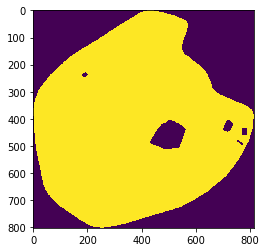

In [7]:
aoi3_nanmask = buildMask(aoi3)
plt.imshow(aoi3_nanmask)

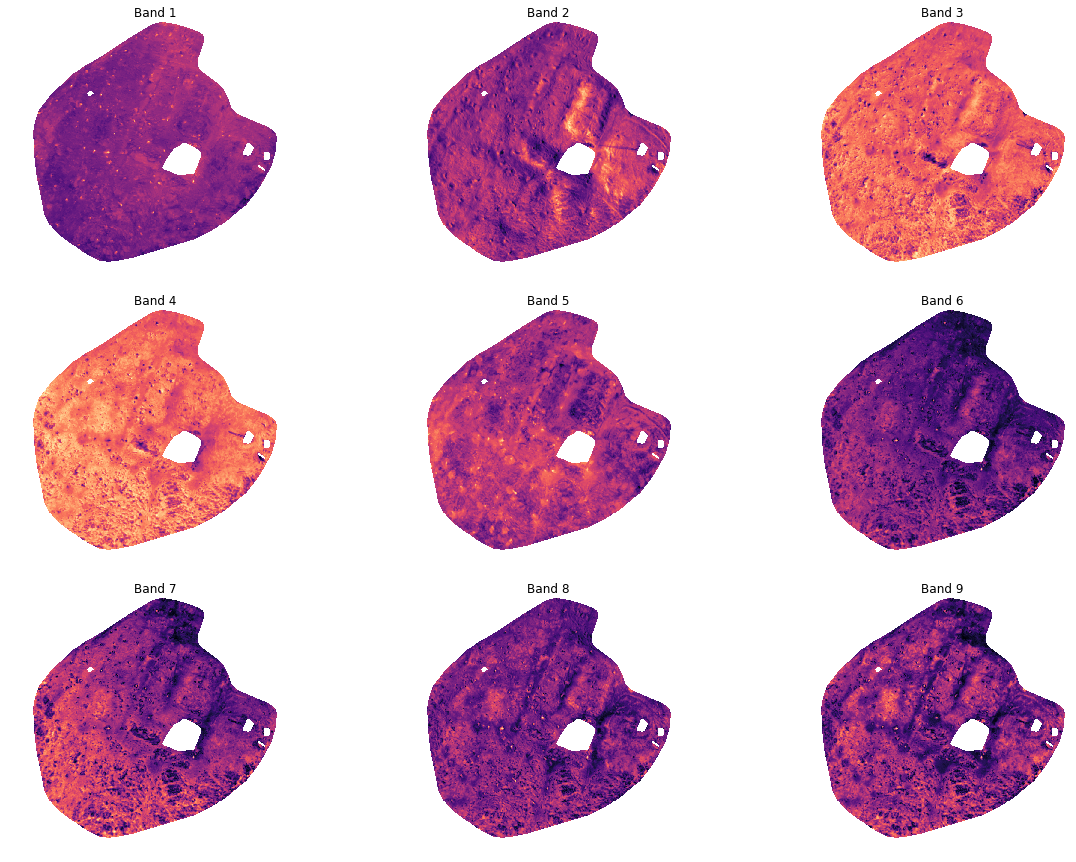

In [8]:
plt.figure(figsize=(20,15))
for band in range(aoi3.shape[0]):
    plot = band+1
    col = 3
    row = math.ceil(aoi3.shape[0]/col)
    
    plt.subplot(row, col, plot)
    plt.title('Band {}'.format(band+1))
    plt.axis('off')
    plt.imshow(aoi3[band], cmap='magma')

### Cast labels raster as NumPy array, build boolean mask, etc.

In [9]:
labels = arcpy.RasterToNumPyArray(inlabels_aoi3)
labels.shape

(802, 814)

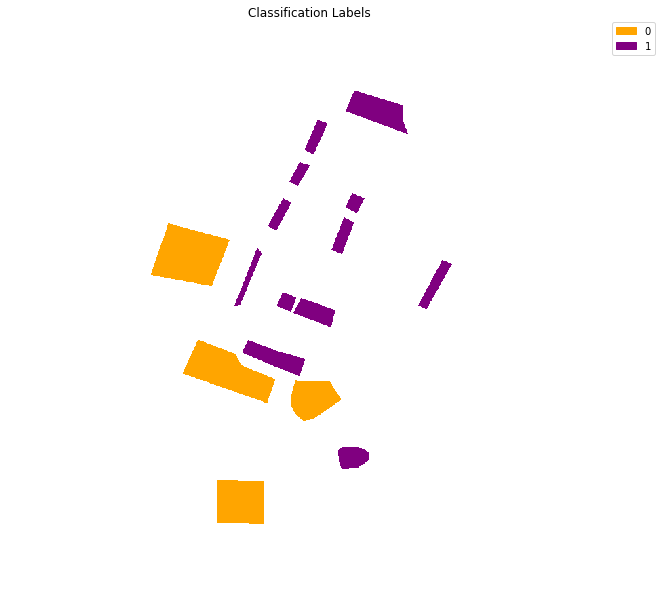

In [10]:
# https://stackoverflow.com/questions/25482876/how-to-add-legend-to-imshow-in-matplotlib
from matplotlib import colors
import matplotlib.patches as mpatches

mycmap = colors.ListedColormap(['white', 'orange', 'purple'])
bounds=[-1,0,1]
norm = colors.BoundaryNorm(bounds, mycmap.N)

plt.figure(figsize=(10,10))
plt.title('Classification Labels')
plt.axis('off')
im = plt.imshow(labels, cmap=mycmap)
values = np.unique(labels.ravel())
colors2 = [ im.cmap(im.norm(value)) for value in values]
# create a patch (proxy artist) for every color 
patches = [ mpatches.Patch(color=colors2[i], label="{l}".format(l=values[i]) ) for i in range(len(values)) ][1:]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )

plt.show()

In [11]:
elements, counts = np.unique(labels, return_counts=True)
print('{} labeled pixels'.format(counts[1] + counts[2]))
print('{} negative locations'.format(counts[1]))
print('{} positive locations'.format(counts[2]))

33978 labeled pixels
20679 negative locations
13299 positive locations


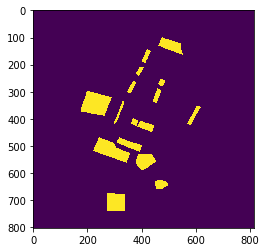

In [12]:
label_mask = np.logical_not(labels < 0)
plt.imshow(label_mask)

### Extract AOI3 by labeled training locations

In [13]:
def extractByMask(band, mask):
    extract = np.copy(band)
    extract[mask==False] = np.nan
    return extract

In [14]:
aoi3_extract = np.array([extractByMask(aoi3[band], label_mask) for band in range(aoi3.shape[0])])
aoi3_extract.shape

(9, 802, 814)

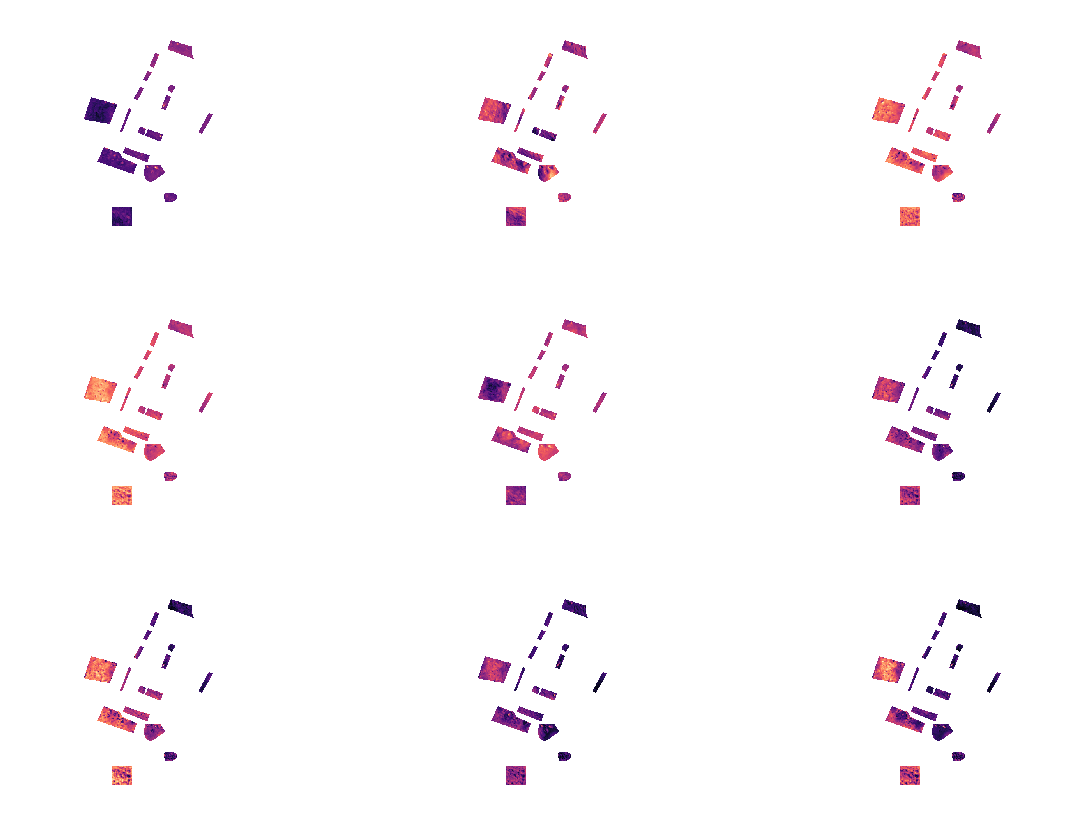

In [15]:
plt.figure(figsize=(20,30))
for band in range(aoi3_extract.shape[0]):
    plot = band+1
    col = 3
    row = 6
    
    plt.subplot(row, col, plot)
    #plt.title('Flt{}'.format(band))
    plt.axis('off')
    plt.imshow(aoi3_extract[band], cmap='magma')

### Flatten and transpose shape of extracted training pixels
#### (From (band, pixel) to (pixel, band))

In [16]:
aoi3_extract_flat = np.array([aoi3_extract[band][label_mask].flatten() for band in range(aoi3_extract.shape[0])])
aoi3_extract_flat = np.transpose(aoi3_extract_flat)
aoi3_extract_flat.shape

(33978, 9)

#### Flatten labels

In [17]:
labels_flat = labels[label_mask]
labels_flat.shape

(33978,)

## Split AOI3 labeled pixels into training and testing dataset.
#### 80% of dataset used to training, 20% used for testing
#### While this errs above the typical training:testing ratio, this seemed appropriate due to the relatively small number of training samples (only ~34k)

In [18]:
from sklearn.model_selection import train_test_split

In [19]:
X_train, X_test, y_train, y_test = train_test_split(aoi3_extract_flat, labels_flat, test_size=0.20, random_state=42)

## Import Support-Vector Classifier and GridSearch parameter optimizer
#### A Support-Vector Machine classifier was selected due to its versatile classification characteristics and ability to to differentiate classes without a clearly defined linear boundary via different kernels. This ability to perform non-linear classification is of particular interest with the current dataset. A significant amount of overlap between the two classes makes a simple linear boundary impossible.
#### GridSearchCV was used to pass the classfier a wide range of parameters to be used when training the model. A new SVC model is exhaustively trained using each combination parameters. The results of each parameter combination are cross valiated to determine the most successful model.

In [20]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

In [21]:
param_grid = [
  {'C': [1, 10, 100, 1000, 10000], 'kernel': ['linear'], 'class_weight':[None, 'balanced']},
  {'C': [1, 10, 100, 1000, 10000], 'gamma': [10, 1, 0.1, 0.01, 0.001, 0.0001], 'kernel': ['rbf'], 'class_weight':[None, 'balanced']},
  {'C': [1, 10, 100, 1000, 10000], 'kernel': ['poly'], 'degree':[5,4,3,2], 'class_weight':[None, 'balanced']}
 ]

In [22]:
supportVector = SVC()

In [23]:
gridSearch = GridSearchCV(supportVector, param_grid)

In [24]:
start = time.clock()
gridSearch.fit(X_train, y_train)

C:\Users\samle\AppData\Local\ESRI\conda\envs\arcgispro-pyre\lib\site-packages\sklearn\model_selection\_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\samle\AppData\Local\ESRI\conda\envs\arcgispro-pyre\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\samle\AppData\Local\ESRI\conda\envs\arcgispro-pyre\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\U

C:\Users\samle\AppData\Local\ESRI\conda\envs\arcgispro-pyre\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\samle\AppData\Local\ESRI\conda\envs\arcgispro-pyre\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\samle\AppData\Local\ESRI\conda\envs\arcgispro-pyre\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this 

C:\Users\samle\AppData\Local\ESRI\conda\envs\arcgispro-pyre\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\samle\AppData\Local\ESRI\conda\envs\arcgispro-pyre\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\samle\AppData\Local\ESRI\conda\envs\arcgispro-pyre\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this 

C:\Users\samle\AppData\Local\ESRI\conda\envs\arcgispro-pyre\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\samle\AppData\Local\ESRI\conda\envs\arcgispro-pyre\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\samle\AppData\Local\ESRI\conda\envs\arcgispro-pyre\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this 

C:\Users\samle\AppData\Local\ESRI\conda\envs\arcgispro-pyre\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\samle\AppData\Local\ESRI\conda\envs\arcgispro-pyre\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\samle\AppData\Local\ESRI\conda\envs\arcgispro-pyre\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this 

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'C': [1, 10, 100, 1000, 10000], 'kernel': ['linear'], 'class_weight': [None, 'balanced']}, {'C': [1, 10, 100, 1000, 10000], 'gamma': [10, 1, 0.1, 0.01, 0.001, 0.0001], 'kernel': ['rbf'], 'class_weight': [None, 'balanced']}, {'C': [1, 10, 100, 1000, 10000], 'kernel': ['poly'], 'degree': [5, 4, 3, 2], 'class_weight': [None, 'balanced']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [25]:
print('GRIDSEARCH RUN TIME: {} seconds'.format(time.clock()-start))

GRIDSEARCH RUN TIME: 5172.1021496 seconds


In [26]:
pd.DataFrame(gridSearch.cv_results_)

C:\Users\samle\AppData\Local\ESRI\conda\envs\arcgispro-pyre\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\samle\AppData\Local\ESRI\conda\envs\arcgispro-pyre\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\samle\AppData\Local\ESRI\conda\envs\arcgispro-pyre\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_scor

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_class_weight,param_kernel,param_gamma,param_degree,params,...,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,3.388267,1.322746,0.552853,0.012024,1,None,linear,NaN,NaN,"{'C': 1, 'class_weight': None, 'kernel': 'line...",...,0.876393,0.875607,0.876168,0.000399,64,0.876773,0.876883,0.875345,0.876334,0.000701
1,3.314470,0.037896,0.548524,0.000816,1,balanced,linear,NaN,NaN,"{'C': 1, 'class_weight': 'balanced', 'kernel':...",...,0.870654,0.870530,0.870319,0.000390,75,0.872192,0.871420,0.869109,0.870907,0.001310
2,2.717051,0.032035,0.505661,0.018420,10,None,linear,NaN,NaN,"{'C': 10, 'class_weight': None, 'kernel': 'lin...",...,0.878049,0.878477,0.878854,0.000854,60,0.878042,0.879146,0.878821,0.878670,0.000463
3,3.266928,0.037874,0.504335,0.002342,10,balanced,linear,NaN,NaN,"{'C': 10, 'class_weight': 'balanced', 'kernel'...",...,0.874296,0.875828,0.875690,0.001086,65,0.875393,0.875835,0.874628,0.875285,0.000499
4,4.708754,0.064043,0.486687,0.001627,100,None,linear,NaN,NaN,"{'C': 100, 'class_weight': None, 'kernel': 'li...",...,0.878270,0.878698,0.879185,0.001007,57,0.878373,0.879201,0.878877,0.878817,0.000341
5,5.753364,1.145059,0.604402,0.157278,100,balanced,linear,NaN,NaN,"{'C': 100, 'class_weight': 'balanced', 'kernel...",...,0.874186,0.875607,0.875506,0.001039,66,0.875779,0.876387,0.874517,0.875561,0.000779
6,15.620193,0.244893,0.492020,0.009081,1000,None,linear,NaN,NaN,"{'C': 1000, 'class_weight': None, 'kernel': 'l...",...,0.878380,0.878256,0.879001,0.000967,59,0.878649,0.879311,0.879263,0.879074,0.000301
7,15.139189,0.781569,0.492011,0.001691,1000,balanced,linear,NaN,NaN,"{'C': 1000, 'class_weight': 'balanced', 'kerne...",...,0.874186,0.875166,0.875359,0.001045,68,0.875835,0.876221,0.874848,0.875635,0.000578
8,104.059162,6.774160,0.667859,0.110627,10000,None,linear,NaN,NaN,"{'C': 10000, 'class_weight': None, 'kernel': '...",...,0.878049,0.878587,0.879038,0.001041,58,0.878318,0.879311,0.878821,0.878817,0.000406
9,107.562538,1.868811,0.536568,0.054722,10000,balanced,linear,NaN,NaN,"{'C': 10000, 'class_weight': 'balanced', 'kern...",...,0.874076,0.875166,0.875432,0.001231,67,0.875779,0.876442,0.874848,0.875690,0.000654


### GridSearch identitfied a Radial-Bias-Function (rfb) kernel with parameters detailed below as the most successful parameter combination
#### Future improvements to the model might be made by fine tuning the parameters used in the final SVM classifications

In [27]:
gridSearch.best_estimator_

SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=10, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [28]:
gridSearch.best_params_

{'C': 1000, 'class_weight': None, 'gamma': 10, 'kernel': 'rbf'}

In [29]:
gridSearch.best_score_

0.9360974174085792

### Train discrete SVC classifier based on the best parameters identified in GridSearch

In [30]:
bestSVC = gridSearch.best_estimator_

In [31]:
start = time.clock()
bestSVC.fit(X_train, y_train)

SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=10, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [32]:
print('BESTSVM TRAINING, RUN TIME: {} seconds'.format(time.clock()-start))

BESTSVM TRAINING, RUN TIME: 67.66224239999974 seconds


In [33]:
aoi3test_preds = bestSVC.predict(X_test)
aoi3test_preds

array([0, 0, 0, ..., 0, 0, 0], dtype=int8)

## Evaluate the accuracy of the BestSVC trained model on testing data
### Overall F1 score of 94% with >90% precision and recall for both classes

In [34]:
from sklearn.metrics import classification_report, confusion_matrix

In [35]:
print(classification_report(y_test, aoi3test_preds))

              precision    recall  f1-score   support

           0       0.96      0.94      0.95      4105
           1       0.91      0.94      0.92      2691

   micro avg       0.94      0.94      0.94      6796
   macro avg       0.94      0.94      0.94      6796
weighted avg       0.94      0.94      0.94      6796



In [36]:
print(confusion_matrix(y_test, aoi3test_preds))

[[3862  243]
 [ 168 2523]]


### Classify all labeled training data based on BestSVC model
#### Note: classification metrics for these predictions should not be used to assess model accuracy valid since they contain the training data themself. The purpose of these predictions is simply to visualize the classification results 

In [37]:
start = time.clock()
aoi3_extract_preds = bestSVC.predict(aoi3_extract_flat)

In [38]:
print('BESTSVM PREDICTIONS, AOI1 (EXTRACT), RUN TIME: {} seconds'.format(time.clock()-start))

BESTSVM PREDICTIONS, AOI1 (EXTRACT), RUN TIME: 3.2327737999994497 seconds


In [39]:
aoi3_extract_preds.shape

(33978,)

In [40]:
aoi3_extract_preds

array([1, 1, 1, ..., 0, 0, 0], dtype=int8)

In [41]:
aoi3_extract_preds_rast = np.copy(aoi3_extract[0])
aoi3_extract_preds_rast[label_mask] = aoi3_extract_preds

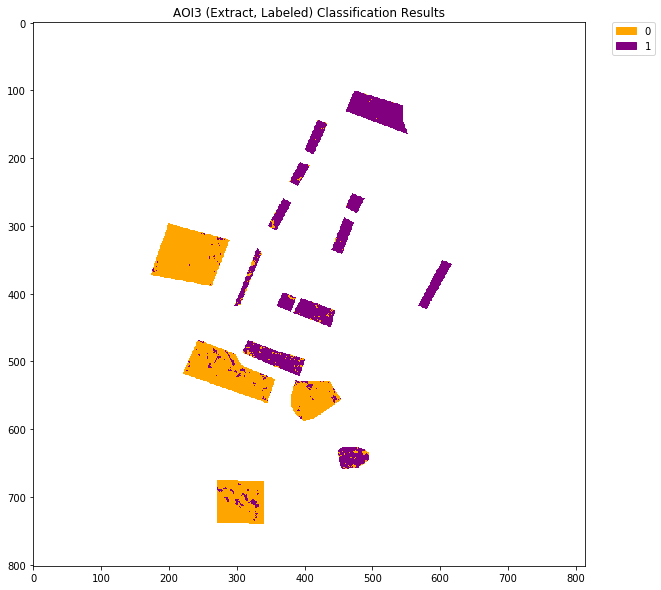

In [42]:
mycmap = colors.ListedColormap(['orange', 'purple'])
bounds=[0,1]
norm = colors.BoundaryNorm(bounds, mycmap.N)

plt.figure(figsize=(10,10))
plt.title('AOI3 (Extract, Labeled) Classification Results')
im = plt.imshow(aoi3_extract_preds_rast, cmap=mycmap)
values = np.unique(labels.ravel())
colors2 = [ im.cmap(im.norm(value)) for value in values]
# create a patch (proxy artist) for every color 
patches = [ mpatches.Patch(color=colors2[i], label="{l}".format(l=values[i]) ) for i in range(len(values)) ][1:]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )

plt.show()

#### Again, the following classification results should not be used as indicative of model accuracy. These metrics are used only for exploratory purposes.

In [43]:
print(classification_report(labels_flat, aoi3_extract_preds))

              precision    recall  f1-score   support

           0       0.97      0.95      0.96     20679
           1       0.92      0.95      0.94     13299

   micro avg       0.95      0.95      0.95     33978
   macro avg       0.94      0.95      0.95     33978
weighted avg       0.95      0.95      0.95     33978



In [44]:
print(confusion_matrix(labels_flat, aoi3_extract_preds))

[[19615  1064]
 [  689 12610]]


### Save AOI3 labeled classification results back to georeferenced raster

In [45]:
rastExtent_aoi3 = arcpy.Raster(inflir_aoi3).extent
lowerLeft_aoi3 = arcpy.Point(rastExtent_aoi3.XMin, rastExtent_aoi3.YMin)

In [46]:
spatRef_aoi3 = arcpy.Describe(inflir_aoi4).spatialReference
spatRef_aoi3.name

'NAD_1983_UTM_Zone_13N'

In [47]:
outRast = 'AOI3_9_Classified_extract_SVM'

aoi3_extract_classified = arcpy.NumPyArrayToRaster(aoi3_extract_preds_rast, lower_left_corner=lowerLeft_aoi3, x_cell_size=0.06, y_cell_size=0.06)
aoi3_extract_classified = arcpy.sa.Int(aoi3_extract_classified)
aoi3_extract_classified.save(outRast)
arcpy.DefineProjection_management(outRast, spatRef_aoi3)

SystemError: <built-in function __import__> returned a result with an error set

SystemError: <built-in function __import__> returned a result with an error set

SystemError: <built-in function __import__> returned a result with an error set

<Result 'C:\\Users\\samle\\Documents\\UT_Dallas\\2019_Spring\\GISC6317_GISProgrammingFundamentals\\FinalProject\\Levin_GISC6317Final.gdb\\AOI3_9_Classified_extract_SVM'>

### Classify entire AOI3 based on extracted training samples model

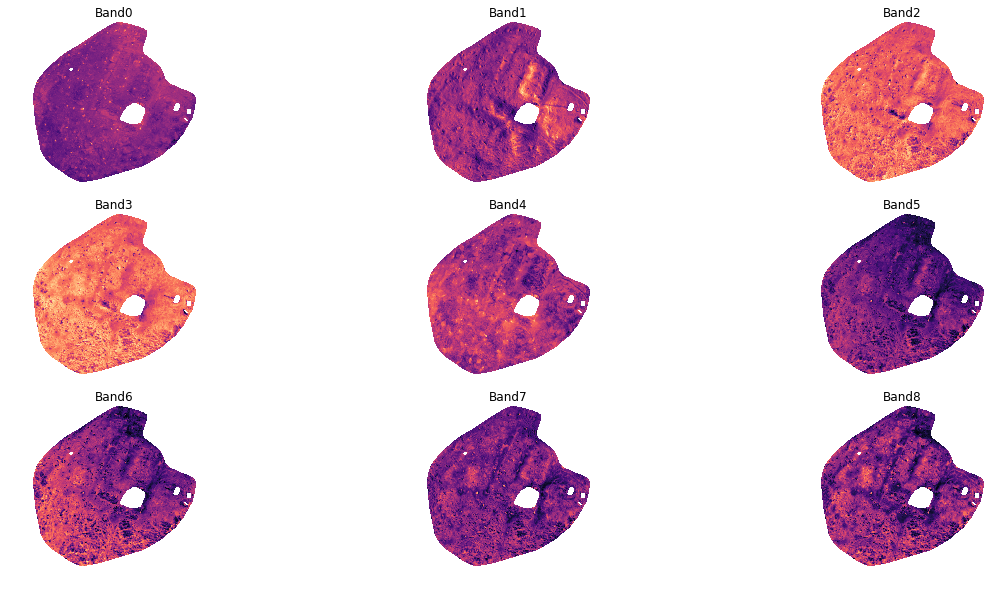

In [48]:
plt.figure(figsize=(20,10))
for band in range(aoi3.shape[0]):
    plot = band+1
    col = 3
    row = math.ceil(aoi3.shape[0]/col)
    
    plt.subplot(row, col, plot)
    plt.title('Band{}'.format(band))
    plt.axis('off')
    plt.imshow(aoi3[band], cmap='magma')

In [49]:
aoi3_flat = np.array([aoi3[band][aoi3_nanmask].flatten() for band in range(aoi3.shape[0])])
aoi3_flat = np.transpose(aoi3_flat)
aoi3_flat.shape

(430310, 9)

In [50]:
start = time.clock()
aoi3_preds = bestSVC.predict(aoi3_flat)

In [51]:
print('BESTSVM, AOI1 PREDICTIONS, RUN TIME: {} seconds'.format(time.clock()-start))

BESTSVM, AOI1 PREDICTIONS, RUN TIME: 40.44454250000035 seconds


In [52]:
aoi3_preds.shape

(430310,)

In [53]:
aoi3_preds

array([0, 0, 0, ..., 0, 0, 0], dtype=int8)

In [54]:
aoi3_preds_rast = np.copy(aoi3[0])
aoi3_preds_rast[aoi3_nanmask] = aoi3_preds

### Visualization of classification results for all AOI3. 
#### The positively identified features (1) show distinct spatial patterning indicative of the structural features. Nevertheless, noise is present throughout the classified results.

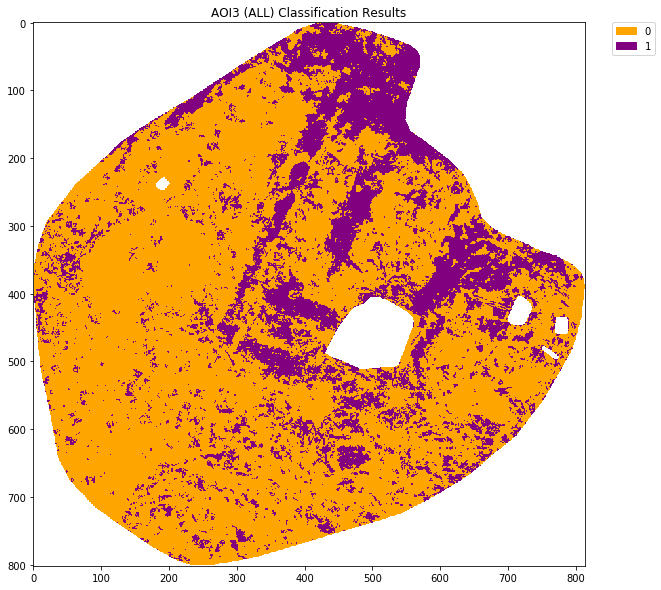

In [55]:
mycmap = colors.ListedColormap(['orange', 'purple'])
bounds=[0,1]
norm = colors.BoundaryNorm(bounds, mycmap.N)

plt.figure(figsize=(10,10))
plt.title('AOI3 (ALL) Classification Results')
im = plt.imshow(aoi3_preds_rast, cmap=mycmap)
values = np.unique(labels.ravel())
colors2 = [ im.cmap(im.norm(value)) for value in values]
# create a patch (proxy artist) for every color 
patches = [ mpatches.Patch(color=colors2[i], label="{l}".format(l=values[i]) ) for i in range(len(values)) ][1:]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )

plt.show()

### Save entire AOI3 classification results back to georeferenced raster

In [56]:
outRast = 'AOI3_9_Classified_SVM'

aoi3_classified = arcpy.NumPyArrayToRaster(aoi3_preds_rast, lower_left_corner=lowerLeft_aoi3, x_cell_size=0.06, y_cell_size=0.06)
aoi3_classified = arcpy.sa.Int(aoi3_classified)
aoi3_classified.save(outRast)
arcpy.DefineProjection_management(outRast, spatRef_aoi3)

<Result 'C:\\Users\\samle\\Documents\\UT_Dallas\\2019_Spring\\GISC6317_GISProgrammingFundamentals\\FinalProject\\Levin_GISC6317Final.gdb\\AOI3_9_Classified_SVM'>

## Classify AOI4 based on AOI3 trained SVM model

In [57]:
aoi4 = arcpy.RasterToNumPyArray(inflir_aoi4, nodata_to_value=np.nan)
aoi4.shape

(9, 665, 937)

In [58]:
aoi4.shape[1] * aoi4.shape[2]

623105

In [59]:
aoi4_nanmask = buildMask(aoi4)

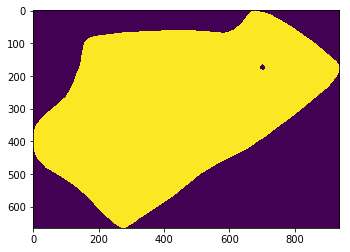

In [60]:
plt.imshow(aoi4_nanmask)

In [61]:
for band in range(aoi4.shape[0]):
    nanmask = np.logical_not(np.isnan(aoi4[band]))
    print(aoi4[band][nanmask].shape)

(354064,)
(354064,)
(354064,)
(354064,)
(354064,)
(354064,)
(354064,)
(354064,)
(354064,)


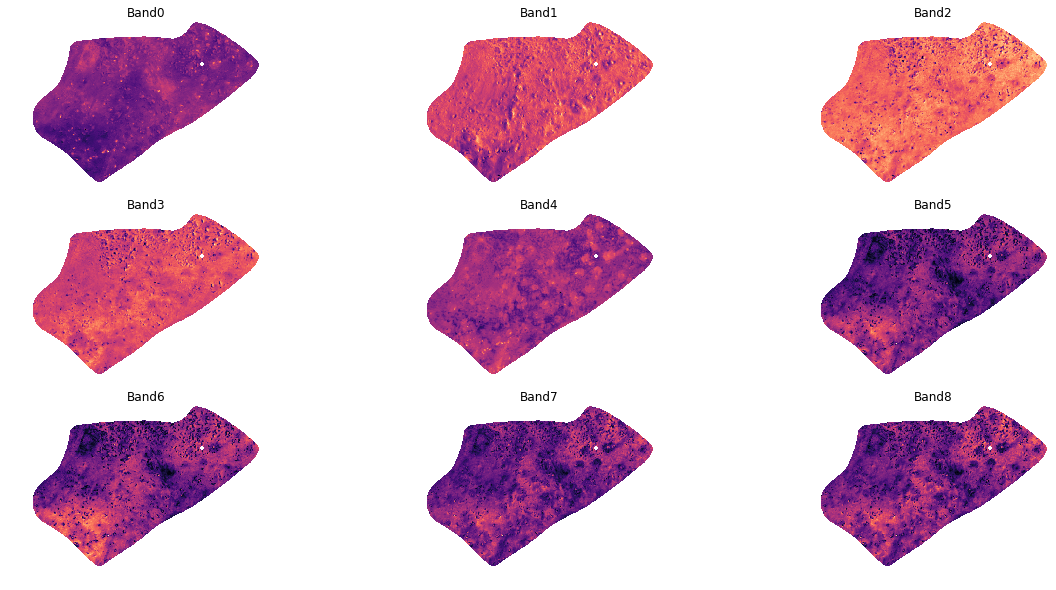

In [62]:
plt.figure(figsize=(20,10))
for band in range(aoi4.shape[0]):
    plot = band+1
    col = 3
    row = math.ceil(aoi4.shape[0]/col)
    
    plt.subplot(row, col, plot)
    plt.title('Band{}'.format(band))
    plt.axis('off')
    plt.imshow(aoi4[band], cmap='magma')

In [63]:
aoi4_flat = np.array([aoi4[band][aoi4_nanmask].flatten() for band in range(aoi4.shape[0])])
aoi4_flat = np.transpose(aoi4_flat)
aoi4_flat.shape

(354064, 9)

In [64]:
start = time.clock()
aoi4_preds = bestSVC.predict(aoi4_flat)

In [65]:
print('BESTSVM, AOI4 PREDICTIONS, RUN TIME: {} seconds'.format(time.clock()-start))

BESTSVM, AOI4 PREDICTIONS, RUN TIME: 39.91890930000045 seconds


In [66]:
aoi4_preds.shape

(354064,)

In [67]:
aoi4_preds

array([0, 0, 0, ..., 0, 0, 0], dtype=int8)

In [68]:
aoi4_preds_rast = np.copy(aoi4[0])
aoi4_preds_rast[aoi4_nanmask] = aoi4_preds

### Classification results of AOI4 based on the model trained at AOI3 are of limited success. There is only vague spatial patterning of positive (1) classified features. One cluster at approx (550, 275) in the figure below has a shape and size similar to a Kiva feature. However, substantial noise throughout the classified result obscures it. The SVC model may be overfit to the AOI3 data. Alternatively, subsurface structural features may not exist in AOI4.  

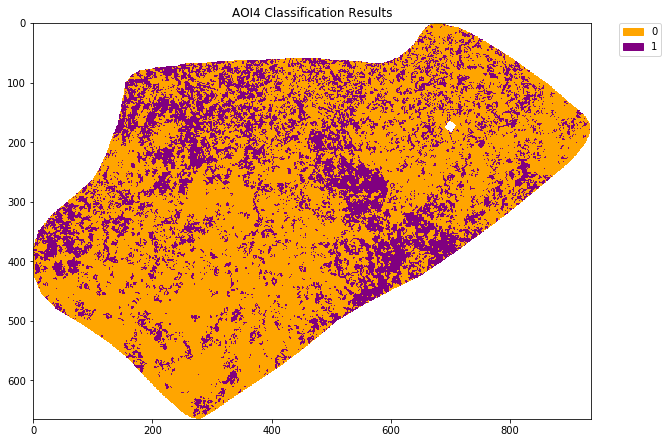

In [69]:
mycmap = colors.ListedColormap(['orange', 'purple'])
bounds=[0,1]
norm = colors.BoundaryNorm(bounds, mycmap.N)

plt.figure(figsize=(10,10))
plt.title('AOI4 Classification Results')
im = plt.imshow(aoi4_preds_rast, cmap=mycmap)
values = np.unique(labels.ravel())
colors2 = [ im.cmap(im.norm(value)) for value in values]
# create a patch (proxy artist) for every color 
patches = [ mpatches.Patch(color=colors2[i], label="{l}".format(l=values[i]) ) for i in range(len(values)) ][1:]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )

plt.show()

### Save AOI4 classification results back to georeferenced raster`

In [70]:
rastExtent_aoi4 = arcpy.Raster(inflir_aoi4).extent
lowerLeft_aoi4 = arcpy.Point(rastExtent_aoi4.XMin, rastExtent_aoi4.YMin)

In [71]:
spatRef_aoi4 = arcpy.Describe(inflir_aoi4).spatialReference
spatRef_aoi4.name

'NAD_1983_UTM_Zone_13N'

In [72]:
outRast = 'AOI4_9_Classified_SVM'

aoi4_classified = arcpy.NumPyArrayToRaster(aoi4_preds_rast, lower_left_corner=lowerLeft_aoi4, x_cell_size=0.06, y_cell_size=0.06)
aoi4_classified = arcpy.sa.Int(aoi4_classified)
aoi4_classified.save(outRast)
arcpy.DefineProjection_management(outRast, spatRef_aoi4)

<Result 'C:\\Users\\samle\\Documents\\UT_Dallas\\2019_Spring\\GISC6317_GISProgrammingFundamentals\\FinalProject\\Levin_GISC6317Final.gdb\\AOI4_9_Classified_SVM'>